<a id='beginning_CRVA'></a>
# Climate Risk and Vulnerability Analysis
This notebook helps you download and visualize climate data to perform Climate Risk and Vulnerability analyses

## Usage
this is how to use this script

1. [Define user input](#user_input)
2. [Run wanted climate variables](#climate_variables)
    1. [Atmosphere's climate variables](#atmosphere_climate_variables)
    2. [Land climate's variables](#land_climate_variables)
    3. [Hydrosphere's climate variables](#hydrosphere_climate_variables)
    4. [Second effect's climate variables](#second_effect_climate_variables)
3. [Export data](#Export)

## Input data

* [Shapefile with project location(s) as points or polygon](#load_shapefile)
* List of variables
* List of SSP's
* List of time horizons

## [Climate variables](#climate_variables)
### [Atmosphere's climate variables](#atmosphere_climate_variables)
* [Precipitation](#worldbank)
* [Temperature](#worldbank)
* [Wind](#wind)
* [Humidity](#humidity)
* [Solar radiation](#solar_radiation)
* Air quality deterioration
### [Land's climate variables](#land_climate_variables)
* [Landslides](#landslides)
* Coastal erosion
* Soil erosion
* Soil salinity
### [Hydrosphere's climate variables](#hydrosphere_climate_variables)
* [Relative sea level rise](#relative_sea_level_rise)
* [Seawater temperature](#sea_water_temperature)
* [Water availability](#water_availability)
* floods (fluvial)
* floods (coastal)
* forest fires
### [Second effects of climate variables](#second_effect_climate_variables)
* Storms
* Dust storms
* Wildfire
* Urban heat island
* Growinf season length
* [cyclone risk](#cyclone_risk)



* earthquakes (not climate related)

## Climate impacts
* calculate impact on yields

## [Climate change information concerning the projects in the study area](#climate_change_info_for_each_project_in_study_area)


## Contact

rapy@cowi.com


<a id='user_input'></a>
## User inputs

[Home](#beginning_CRVA)

In [1]:
#User inputs
import os.path


#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#output folder
#out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs'
out_path_database=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)


#### Year of study
#IDEA IS TO GIVE POSSIBILITY FOR THE USER TO CHOOSE DEPENDING on PROJECT (could choose on year or a period but precise period make more sense)
#SET by default for the moment

first_year = 2025 # start year included
last_year = 2026 # last year included


# For data coming from copernicus, historical data are commonly 1850-2005

## Import python packages

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_8068\3509116232.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


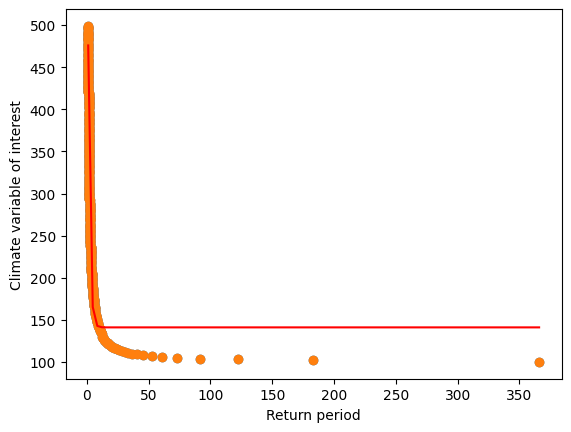

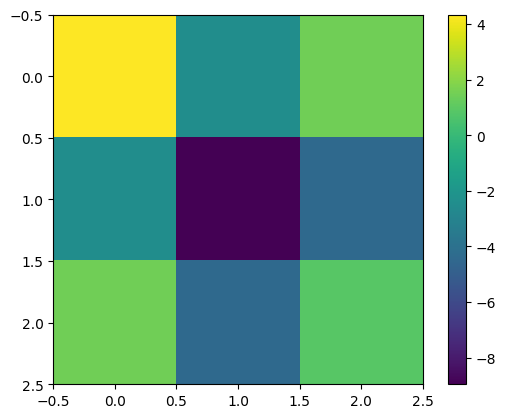

In [3]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D

# to perform bias correction
from bias_correction import BiasCorrection, XBiasCorrection
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gamma, norm
from scipy.signal import detrend

# import functions and class defined in another file named FunctionsAndClass
## Functions
from FunctionsAndClass import copernicus_data
from FunctionsAndClass import year_copernicus
from FunctionsAndClass import date_copernicus
from FunctionsAndClass import csv_copernicus
from FunctionsAndClass import Display_map
from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name
from FunctionsAndClass import Display_map_projects
from FunctionsAndClass import register_data # import to test
from FunctionsAndClass import find_column_name # import to test
from FunctionsAndClass import search_for_nc # import to test
from FunctionsAndClass import try_download_copernicus # import to test


## Class
from FunctionsAndClass import calendar
from FunctionsAndClass import copernicus_elements
from FunctionsAndClass import map_elements

<a id='load_shapefile'></a>
## Load shapefiles and plot

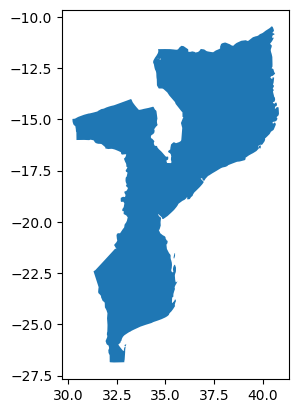

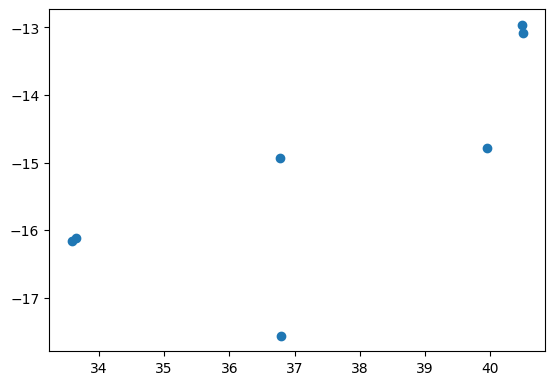

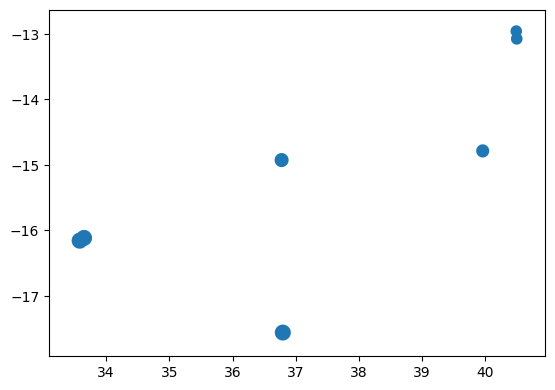

In [4]:
#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
area_projects = [lat_projects - 5, lat_projects+5, lon_projects-5,lon_projects+5] # list format
# 5 degres trop grand 
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

area = [lat_min_wanted, lon_min_wanted, lat_max_wanted,lon_max_wanted,] # used to download from copernicus

### YEAR
year = np.arange(first_year,(last_year+1),1) # create vector of years
year_str = [0]*len(year) # create initiale empty vector to convert years in int
index = np.arange(0,len(year)) # create vector of index for year
i = 0 # initialize index
for i in index: # convert all the date in string format
    year_str[i]=str(year[i])

start_date = "01-01-"+year_str[0] # string start date based on start year
stop_date = "31-12-"+year_str[len(year)-1] # string stop date based on stop year
dates = pd.date_range(start_date,stop_date) # vector of dates between start date and stop date
index_dates = np.arange(0,len(dates)) # vector containning index o dates vector

In [5]:
lat_min_wanted

-24.422

In [6]:
lon_min_wanted

17.923000000000002

In [7]:
lat_max_wanted

-4.422000000000001

In [8]:
lon_max_wanted

57.923

In [ ]:
base = study_area.plot(color='white', edgecolor='black')
projects.plot(ax=base, marker='o', color='blue', markersize=5);

In [ ]:
library(NASAaccess)

NEX_GDDP_CMIP6(Dir = "./NEX_GDDP_CMIP6/", 
               watershed = shape_path,
              dem_path,  
              start = "2060-12-1", 
              end = "2060-12-3",
              model = 'ACCESS-CM2', 
              type = 'tas', 
              slice = 'ssp245')

In [ ]:
import requests

filepath = 'https://ds.nccs.nasa.gov/thredds2/fileServer/AMES/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc'


In [ ]:
import csv
import os
import hashlib
import logging
from subprocess import run as srun
from urllib.parse import urlparse
logging.basicConfig(level=logging.INFO)
def download(uri, ofile, md5):
    srun(['curl', '-s', '-o', ofile, uri], capture_output=True, check=True) # without curl, file is corrupted
    md5dld = str(hashlib.md5(open(ofile, 'rb').read()).hexdigest())
    if md5 != md5dld:
        logging.warning("%s != %s", md5, md5dld)
    logging.info("uri %s (%s == %s) : %s", uri, md5, md5dld, ofile)

with open('gddp-cmip6-thredds-fileserver.csv') as index:
    fobjects = csv.reader(index)
    next(fobjects)
    next(fobjects)
    next(fobjects)
    next(fobjects)
    for objs in fobjects:
        md5, uri = [o.strip() for o in objs]
        prsout = urlparse(uri)
        ofile = os.path.split(prsout.path)[1]
        download(uri, ofile, md5)

In [ ]:
os.path.isfile('hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc')

In [ ]:
Dataset("hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc", format='NETCDF4_CLASSIC')

In [ ]:
import gc
import os

import click
import pandas as pd
import xarray as xr
from xsd.bcsd import bcsd, disagg



<a id='climate_variables'></a>
# Climate variables

[Home](#beginning_CRVA)

<a id='atmosphere_climate_variables'></a>
# ATMOSPHERE

[Home](#beginning_CRVA)

<a id='worldbank'></a>
## World Bank Climate knowledge portal, Precipitation and Temperature - Atmosphere
data source: https://climateknowledgeportal.worldbank.org/download-data

List of different variables:

### Precipitation 
* return period of current 50 and 100 year event
* yearly average precipitation
* seasonal average precipitation - OR MONTH? i word documnet: average dry season precipitation 
* maximum precipitation in one day - NOT REALLY, instead "Average of the largest daily precipitation amount" rx1day 
* maximum precipitation in five days - NOT REALLY, instead "Average of the largest 5-day consecutive precipitation amount".
* FORSLAG: Could also include: precipitation amount from very wet days/ days >50mm. eg. 

### Temperature
* Yearly mean temperature (average) - tas 
* Number of hot days >40 degrees C (average)
* Number of hot days >35 degrees C (average) 
* Maximum of daily max-temperature (per year) -txx
* Average of maximum temperature (daily??) - tasmax 

### How to use
define 

`variables = {variablename1:{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, variablename2:...}`

where variablename corresponds to a variable name in the cckp, periods include the desired periods, ssps the desired ssp-rcp scenarios, and gcms can be either median, p10, or p90 (50%, 10%, and 90% percentile of ensemble models).

In [ ]:
#Read downloaded precipitation and temperature data
#settings

variables= {
    #Temperature
        #era/cru
            #'climatology-hd35-annual-mean_era':{'periods':['1991-2020']},
            'climatology-hd40-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_era':{'periods':['1991-2020']}, 
            'climatology-tas-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_cru':{'periods':['1991-2020']}, 
        #realtime
            'climatology-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median']},
            #'anomaly-hd35':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-tasmax':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'anomaly-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #txx=maximum of daily max temperature
            'climatology-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-tas':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-tas':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #data not downloaded 
    #Precipitation
       #era/cru
            #'climatology-r50mm-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-rx1day-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-rx1day-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_cru':{'periods':['1991-2020']},
        #realtime
            'frp100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039','2035-2064'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'frp50yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx5day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx1day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-monthly-mean_cmip6_monthly':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-seasonal-mean_cmip6_seasonal':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'changefactorfaep100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-pr-monthly-mean_cmip6_monthly':{'periods':['2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}
            }
       ## 'timeseries-rx1day':{'periods':['2015-2100'],'ssps':['ssp245'],'gcms':['median']} # Den kan ikke læse den - brokker sig over Dimension time=0. 
       
#Create multi index for cckp_output
idx=pd.IndexSlice
mindex=[]
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']:
            mindex.append((var,period,None,None))
        else:
            for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        mindex.append((var,period,ssp,gcm))
mindex=pd.MultiIndex.from_tuples(mindex, names=['variable', 'period','ssp','gcm'])
#cckp_output=pd.DataFrame(index=projects[project_id],columns=mindex)
cckp_output=pd.DataFrame(index=mindex,columns=projects[project_id])

#read data from cckp and spatial statistics
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']: # for era/cru data
            varname='_'.join((var,period))
            data_path=get_cckp_file_name(var,period=period)
            if os.path.exists(data_path):
                data=read_cckp_ncdata(data_path)
                stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                projects[varname]=stats
                #cckp_output.loc[:,idx[var,period,:,:]]=stats.values
                cckp_output.loc[idx[var,period,:,:],:]=stats.T.values
            else:
                print(data_path,"not found")
                projects[varname]='not found'
        elif period not in ['1991-2020']: #for realtime data 
                for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        varname='_'.join((var,period,ssp,gcm))
                        data_path=get_cckp_file_name(var,ssp=ssp,period=period,gcm=gcm)
                        if os.path.exists(data_path):
                            data=read_cckp_ncdata(data_path)
                            stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                            projects[varname]=stats
                            #cckp_output.loc[:,idx[var,period,ssp,gcm]]=stats.values
                            cckp_output.loc[idx[var,period,ssp,gcm],:]=stats.T.values
                        else:
                            print(data_path,"not found")
                            projects[varname]='not found'


#plot, show #ADD enlarge the clip + something wierd with nodata value
cckp_output.to_csv('outputs/csv/cckp_output.csv')
projects[[project_id,varname]].head()

fig, ax = plt.subplots()
precip = rioxarray.open_rasterio(data)
precip_clip = precip.rio.clip(study_area.geometry, study_area.crs, drop=True)
precip_clip.plot(ax=ax)
projects.plot(ax=ax)

#close
precip.close()

<a id='wind'></a>
## Wind Speed

Daily wind speed, historical and projected.

Data source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

In [ ]:
### Extraction of Near-surface wind speed data
global_variable = 'Wind'
name_variable = 'near_surface_wind_speed'

#### Historical data for wind speed

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1950,2014)
temporal_resolution = 'daily'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
(Wind_historical,period_historical) = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path, name_variable,'sfcWind',area)    

#### Projection data for wind speed

In [ ]:
(year, year_str, index)=year_copernicus(2098,2099)
temporal_resolution = 'daily'

#(df,period) = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,'sfcWind',projects.Name[0],[area_projects[0][0],area_projects[1][0],area_projects[2][0],area_projects[3][0]])

# df with separation of different projects
# separate dataframe function
NameProjects=list(projects['Name'])
#NameProjects.remove('PT1_Pemba - Breidge Paquite')

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
k=0
Temp=[]
for name_project in NameProjects:
    (df,period) = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,name_project,[area_projects[0][k],area_projects[1][k],area_projects[2][k],area_projects[3][k]])  
    Temp.append(df)
    k+=1
# last parameter is the area of one project, elements are fisrt col (min lat = 0, max lat = 1, min lon = 0, max lon = 1), then line (each ligne is coordinates for a project)

In [ ]:
(year, year_str, index)=year_copernicus(2098,2099)
temporal_resolution = 'daily'
### does not work for PT1_Pemba - Breidge Paquite. When extract all, try to extract a json file (no need for it I think)
### this makes everything going bad
(df,period) = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,'sfcWind','PT_ Dumping Site',[area_projects[0][6],area_projects[1][6],area_projects[2][6],area_projects[3][6]])

In [ ]:
projects['Name']

In [ ]:
df

In [ ]:
### BOXPLOTS


df_reordered2 = df.reorder_levels(['Experiment', 'Model', 'Latitude', 'Date']) # reordering to ...
df_reordered2_mean=df_reordered2.groupby(level=[0,1,2],axis=0,group_keys=True).mean()
numpy_array = df_reordered2_mean.loc['ssp1_2_6','access_cm2'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array1 = numpy_array[~np.isnan(numpy_array)]

numpy_array = df_reordered2_mean.loc['ssp1_2_6','awi_cm_1_1_mr'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array2 = numpy_array[~np.isnan(numpy_array)]

numpy_array = df_reordered2_mean.loc['ssp1_2_6','bcc_csm2_mr'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array3 = numpy_array[~np.isnan(numpy_array)]
# boxplot do not deal with NaN, have to take them out
dict_boxplot = plt.boxplot([numpy_array1,numpy_array2,numpy_array3],notch=True, whis =(10,90),widths = 0.15, patch_artist=True,labels=('access_cm2','awi_cm_1_1_mr','bcc_csm2_mr'))#,labels = 'access_cm2')# ... present boxplot over the period for each models
# this functions returns varius parameters of the boxplot in the dict_boxplot. This funcitons also returns an image of it
# here, numpy_array is a vector. But can also include array with several columns. Each columns will have a boxplot
# 'notch' is true to enhance part where the median is
# 'whis' is the percentile value for the whiskers, every data out of the range indicted by those 2 floats are represented as points
# 'widths' determine width of the boxes
# 'patch_artist' colors the boxplots
# 'labels' gives a name to every column included in the data part
str = 'Distribution of the average daily wind speed for different models \nfor the year '+period+' and under scenario ssp1_2_6'
title_png = 'Boxplot_models_ssp1_2_6'
plt.title(str)
plt.xlabel('Models')
plt.ylabel('Average wind speed m/s')
plt.savefig(os.path.join(out_path,'figures','Boxplots',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [ ]:
#### BOXPLOTS


df_reordered3 = df.reorder_levels(['Experiment', 'Model', 'Latitude', 'Date']) # reordering to ...
df_reordered3_mean=df_reordered3.groupby(level=[0,1,2],axis=0,group_keys=True).mean()
numpy_array = df_reordered3_mean.loc['ssp1_2_6'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array4 = numpy_array[~np.isnan(numpy_array)]
# boxplot do not deal with NaN, have to take them out
dict_boxplot = plt.boxplot(numpy_array4,notch=True, whis =(10,90),widths = 0.15, patch_artist=True,labels=('ssp1_2_6',))# ... present boxplot over the period for each models
# this functions returns varius parameters of the boxplot in the dict_boxplot. This funcitons also returns an image of it
# here, numpy_array is a vector. But can also include array with several columns. Each columns will have a boxplot
# 'notch' is true to enhance part where the median is
# 'whis' is the percentile value for the whiskers, every data out of the range indicted by those 2 floats are represented as points
# 'widths' determine width of the boxes
# 'patch_artist' colors the boxplots
# 'labels' gives a name to every column included in the data part
str = 'Distribution of the average daily wind speed accross models\nfor the year 2099-2100 and under scenario ssp1_2_6'
title_png = 'Boxplot_ssp1_2_6'
plt.title(str)
plt.xlabel('Models')
plt.ylabel('Average wind speed m/s')
plt.savefig(os.path.join(out_path,'figures','Boxplots',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

<a id='humidity'></a>
## Humidity

Source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

### Relative humidity

Relative humidity of air: amount if moisture it contains compared to the maximum amount of moisture it can have at a specific temperature

### Extraction of Relative humidity data

In [ ]:
global_variable = 'Relative_Humidity'
name_variable = 'near_surface_relative_humidity' # only available on a monthly basis

#### Historical data

In [ ]:
(year_historical, year_str_historical, index_historical) = year_copernicus(1850,2014)
temporal_resolution = 'monthly'

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Humidity_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projections

In [ ]:
(year, year_str, index) = year_copernicus(2020,2100)
temporal_resolution = 'monthly'

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Humidity = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='solar_radiation'></a>
## Solar radiation

In [ ]:
global_variable = 'Solar_radiation'
# choose of the climate variable from copernicus to represent : choose of surface_downwelling_shortwave_radiation because
# 1. interest for project located at the surface of the Earth
# 2. for most project (for example solar panels), we are interest in radiation going down, not up
# 3. Shortwave radiation are the ones produce by the sun
name_variable = 'surface_downwelling_shortwave_radiation' # only available on a monthly basis

#### Historical data for solar radiation

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1850,2016)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Solar_radiation_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projection for data solar radiation

In [ ]:
## Failed to go the end, separe download and makin one csv for one climate variable with all project, scenario, model and years

(year, year_str, index)=year_copernicus(2016,2099)
temporal_resolution = 'monthly'

Projections_solar_radiation_projects = pd.DataFrame() # create an empty dataframe
for (name_project,k) in zip(projects['Name'],np.arange(0,len(projects['Name']))):
    (df,period) = csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,name_project,[area_projects[0][k],area_projects[1][k],area_projects[2][k],area_projects[3][k]],'CMIP6-copernicus-GCM')  
    Projections_solar_radiation_projects = pd.concat([Projections_solar_radiation_projects,df])
path_for_csv = os.path.join(out_path,'csv','data',name_variable)
Projections_solar_radiation_projects.to_csv('outputs/csv/data/Projections_solar_radiation_projects.csv')

In [ ]:
Future_solar_radiation

In [ ]:
(year, year_str, index)=year_copernicus(2015,2099)
temporal_resolution = 'monthly'
name_project = 'CompleteMozambique'

Projections_solar_radiation_country = pd.DataFrame() # create an empty dataframe
(Projections_solar_radiation_country,period) = csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,name_project,area,'CMIP6-copernicus-GCM')  

### Downscaling complete Mozambique

<a id='land_climate_variables'></a>
# LAND

[Home](#beginning_CRVA)

<a id='landslides'></a>
## Landslides - Land

source: https://datacatalog.worldbank.org/search/dataset/0037584 (Global Landslide Hazard Map, The World Bank)

### Description of LS_TH : 
The Global Landslide Hazard Map presents a qualitative representation of global landslide hazard at a global scale. It is the combination of the The Global Landslide Hazard Map: Median Annual Rainfall-Triggered Landslide Hazard (1980-2018) and The Global Landslide Hazard Map: Earthquake-Triggered Landslide Hazard which has then been simplified to four rank categories, ranging from Very low to High landslide hazard, based on the existing system used by ThinkHazard! (www.thinkhazard.org)

### Description of LS_RF_Median_1980-2018 :
The Global Rainfall-Triggered Landslide Hazard Map presents a quantitative representation of landslide hazard. This component is the median annual rainfall-triggered landslide hazard assessment for the period 1980 – 2018. Raster values represent the modelled average annual frequency of significant rainfall-triggered landslides per sq. km.

In [ ]:

#Landslides data path
landslidesTH_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_th/LS_TH.tif') ## Global landslide hazard map (TH ranks --> Think hazard ranks)
landslidesRF_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_rf_median_1980-2018/LS_RF_Median_1980-2018.tif')

#spatial stats
projects['landslides_THmax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesTH_path, 
                                                            all_touched=True, stats='max'))
projects['landslidesRF_medianMax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesRF_path, 
                                                            all_touched=True, stats='max'))
#show table
projects[[project_id,'landslides_THmax','landslidesRF_medianMax']].head()

#plot landslides TH
fig, ax = plt.subplots()
landslides = rioxarray.open_rasterio(landslidesTH_path)
landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
points=projects.plot(ax=ax,cmap='Greys') # what are those points ????

#close
landslides.close()
landslides_clip.close()

# didn't achieved to present the RF datas
#plot landslides RF
#fig, ax = plt.subplots()
#landslides = rioxarray.open_rasterio(landslidesRF_path)
#landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
#landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
#points=projects.plot(ax=ax,cmap='Greys') # what are those points ????
#landslides.close()

## Global wildfire hazard - Land

This jupyter notebook is to study the global wildfire hazard

Source : https://datacatalog.worldbank.org/search/dataset/0042058/Global-wildfire-hazard

Description of the source : The approach to classify wildfire hazard levels used is based solely on fire weather index climatology. Fire weather indices are used in many countries to assess both the onset of conditions that will allow fires to spread, as well as the likelihood of fire at any point in the landscape. The method presented uses statistical modelling (extreme value analysis) of a 30 year fire weather climatology to assess the predicted fire weather intensity for specific return period intervals. These intensities are classified based on thresholds using conventions to provide hazard classes that correspond to conditions that can support problematic fire spread in the landscape if an ignition and sufficient fuel were to be present.

Date of export : 23.03.23

Projection FWI for europe : https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview

Projection seasonal severity rating of for EUrope : https://www.eea.europa.eu/data-and-maps/figures/projected-meteorological-forest-fire-danger

Calculation of the FWI : https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

GLOBAL PROJeTIONS NOT FOUND


## Soil erosion - Land

Source for global actual situations : https://data.jrc.ec.europa.eu/dataset/jrc-esdac-120

<a id='hydrosphere_climate_variables'></a>
# HYDROSPHERE

[Home](#beginning_CRVA)

<a id='relative_sea_level_rise'></a>
## Relative sea level rise

In [ ]:
## use copernicus or NASA data ? NASA data are in COWI servor \\COWI.net\projects\A245000\A248363\CRVA\Datasets\SeaLevelRise\Nasa
# use mean sea level > https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-water-level-change-indicators-cmip6?tab=overview

<a id='sea_water_temperature'></a>
## Sea water temperature

In [ ]:
global_variable = 'Sea_water_temperature'
name_variable = 'sea_surface_temperature' # only estimate for the surface in the copernicus CMIP6

#### Historical data

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1850,2014)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projection data

In [ ]:
(year, year_str, index)=year_copernicus(2020,2100)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='water_availability'></a>
### Water availability
Represented with water stress

Did not find historical data, look into world bank

Source for projections from 2020 to 2050 : https://www.wri.org/data/aqueduct-water-stress-projections-data
Informations about how the shp is designed located here : data_folder, Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615 (excel sheet)

In [ ]:
## Projection of water stress
# register path to water stress data
water_stress_location_path=os.path.join(data_folder,'Water_Availability_WaterStress/aqueduct_projections_20150309_shp/aqueduct_projections_20150309.shp')
# register data in default projection 4326
water_stress = gpd.read_file(water_stress_location_path).to_crs(bCRS) # uncertain that projeciton is the default one
ws_geometry = water_stress.geometry # register geometry for later
# filter columns of dataframe that are not water stress related
elements_to_drop=('sv','ut','bt','r','u','c','20','BasinID','dwnBasinID','Shape_Leng','Shape_Le_1') # if a column contains a str in this list, the column should be drop
# 20 to remove the projections for 2020 (the projections were made in 2015)

for name_column_out in elements_to_drop:
    water_stress=water_stress.drop(water_stress.filter(regex=name_column_out).columns, axis=1)
    
# making name of columns more precise
# information on column names come from 
#\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615
scenarios_ws=['ssp2_rcp45','ssp2_rcp85','ssp3_rcp85']
projections_ws = ['projection_2030 ','projection_2040 ']
old_name = ['ws', '30','40','24','28','38','tl']
new_name = ['water stress ','projection_2030 ','projection_2040 ','ssp2_rcp45','ssp2_rcp85','ssp3_rcp85','']

for o,n in zip(old_name,new_name): # iterate accross the two list at a time
    water_stress.columns = water_stress.columns.str.replace(o, n) # replacing "40" by "projection_2040" in names of columns
        
# water_stress is a panda dataframe, not geopanda.dataframe. Need to convert it again in geopandas.geodataframe.GeoDataFrame. 
# Otherwise, impossible to use sjoin later
water_stress = GeoDataFrame(water_stress, crs=bCRS, geometry=ws_geometry) # convert panda.dataframe in geopandas.geodataframe.GeoDataFrame

# join information from water stress to projects

projects=projects.sjoin(water_stress,how='left',predicate='within', lsuffix="_left") # need to rename name of columns to make it understandable
projects.drop('index_right', axis=1, inplace=True) # drop column containing index from water stress
projects # projects stays a geopandas.geodataframe.GeoDataFrame

In [ ]:
Display_map_projects(projects,study_area,'water stress','Map presenting water stress projections for Mozambique projects', 2, 3, out_path)
# This function aims to display every projects wanted by the user with a map as a background
### Parameters of the function : 
# projects: geopanda.dataframe containing projects information
# study_area: geopanda.dataframe containing study_area information
# str_interest: string of the climate variable of interest to be represented
# title_for_image: title for image composed of subplots
# number_rows: the user should indicate the number of rows for the subplots
# number_cols: the user should indicate the number of cols for the subplots
# out_path: begenning of the path to register the image

In [ ]:
# select climate variable to be represented
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
columns_to_represent2=[ ('\n').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from 
# the list column_to_represent and insert \n to do a back to line
number_plots = len(columns_to_represent)

# create figure
fig, axs = plt.subplots(nrows=2,ncols=3, sharex=True, sharey=True,figsize=(8,8))

color_dict = {'Low':'green', 'Antarctica':'white', 'Asia':'pink', 
              'Europe':'green', 'North America':'brown',
              'Oceania':'blue', 'Seven seas (open ocean)':'gray',
              'South America':'red'}

# map in the subplot
k = 0

for i in np.arange(0,3):# columns
    for j in np.arange(0,2): # lines
        base = study_area.plot(ax=axs[j][i],color='white', edgecolor='black')# background is map of the study area presenting 
        # country borders of this area
        projects.plot(ax=axs[j][i], column=columns_to_represent[k])# plot the projects as points; legeng = True 
        # impose a color for the projects point depending on the value in the column
        
        # give subplot a title
        ax_created = axs[j][i]
        ax_created.title.set_text(columns_to_represent2[k])
        
        k+=1 # incrementation to iterate columns_to_represent
plr
plt.suptitle('Map presenting water stress projections for Mozambique projects') # give a global name to the image
plt.savefig(os.path.join(out_path,'figures','water stress','Map presenting water stress projections for Mozambique projects'),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [ ]:
np.arange(0,3)

In [ ]:
axs

In [ ]:
projects

In [ ]:
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
columns_to_represent=[ (' ').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from the list column_to_represent

In [ ]:
columns_to_represent

In [ ]:
[s.replace('water stress ', '') for s in columns_to_represent]
columns_to_represent

In [ ]:
# plot results for projects
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
number_plots = len(columns_to_represent)

# trying to do a map with shape of area and points projets
#projects.plot(column='water stress projection_2030 ssp2_rcp45', legend=True)

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharex=True, sharey=True,figsize=(8,8))
#norm = plt.colors.Normalize(vmin=projects.val.min(), vmax=projects.val.max()) # to normalize legend between the different plots
# wait to see if new intallation worked
base = study_area.plot(ax=ax1,color='white', edgecolor='black')
projects.plot(ax=ax1, column='water stress projection_2030 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax2,color='white', edgecolor='black')
projects.plot(ax=ax2, column='water stress projection_2040 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax3,color='white', edgecolor='black')
projects.plot(ax=ax3, column='water stress projection_2030 ssp2_rcp85',legend=True)
#projects.plot(column='water stress projection_2030 ssp2_rcp45',ax=base, legend=True);

<a id='floods'></a>
## Floods - Hydrosphere

####  Fluvial
Sources:
1) JRC Flood Hazard Map, http://data.europa.eu/89h/jrc-floods-floodmapgl_rp100y-tif : The map depicts flood prone areas at global scale for flood events with 100-year return period. Resolution is 30 arcseconds (approx. 1km). Cell values indicate water depth (in m). The map can be used to assess flood exposure and risk of population and assets. NOTE: this dataset is based on JRC elaborations and is not an official flood hazard map (for details and limitations please refer to related publications).
2) Dataset of tropical cyclone Idai and subsequent flood disaster in Southern Africa (March 2019). National Tibetan Plateau Data Center, https://data.tpdc.ac.cn/en/data/8d836d13-a8e6-492b-9324-00fbfce40619/ 

#### Coastal 
Source: WRI Aqueduct database

In [ ]:
# save the path for the image presenting the floods which have a return period of a 100 year
flood_path=os.path.join(data_folder,'floodMapGL_rp100y/floodMapGL_rp100y.tif')

buffer_flood=1000#meters # pas sure : sert a avoir les 
if buffer_flood != 0:
    projects_bufFlood=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_bufFlood['geometry']=projects.to_crs(mCRS).buffer(buffer_flood) #assign the buffer as the new geometry - 
    projects_bufFlood=projects_bufFlood.to_crs(bCRS)#project back to orginal crs

projects['floods100yr_max']=pd.DataFrame(zonal_stats(vectors=projects_bufFlood, raster=flood_path, 
                                                            all_touched=True, stats='max'))
#plot
fig, ax = plt.subplots()
floods = rioxarray.open_rasterio(flood_path)
floods_clip = floods.rio.clip(study_area.geometry, study_area.crs, drop=True)
floods_clip.plot(ax=ax,cmap='Blues',vmin=0,vmax=25)
projects.plot(ax=ax,color='Black') # mapping the projects located in the study area
#cb.set_label('Water depth (m)') # name for color scale ne fonctionne pas car cette ligne appartient a basemap language
ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image

#close
floods_clip.close()
floods.close()

#### Sea level rise

Global Mean Sea Level
Source : https://climate.nasa.gov/vital-signs/sea-level/ ; used the Global Mean Sea Level (Global Isostatic Adjustment (GIA) applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference 

Sea Level Trends
Source : https://sealevel.colorado.edu/trend-map : sea level trend from 1992 to 2022

<a id='second_effect_climate_variables'></a>
# Second effect climate variables

[Home](#beginning_CRVA)

<a id='cyclone_risk'></a>
## Cyclones
data source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en UNEP-GRID, 

cyclone risk level from 1 (low) to 5 (extreme)

In [ ]:
#cyclone data path
cyclone_path=os.path.join(data_folder,'cyclones/unep_grid/cy_risk.tif')
 
   # \\COWI.net\projects\A245000\A248363\CRVA\Datasets\cyclones\unep_grid
#spatial stats
projects['cyclone_risk']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=cyclone_path, all_touched=True, stats='max'))

#show table
projects[[project_id,'cyclone_risk']].head()

#plot
fig, ax = plt.subplots()
cyclone = rioxarray.open_rasterio(cyclone_path)
cyclone_clip = cyclone.rio.clip(study_area.geometry, study_area.crs, drop=True)
cyclone_clip.plot(ax=ax)
projects.plot(ax=ax) # plot the projects on the map

plt.title('Cyclone risk level') # title of the graph

#close
cyclone_clip.close()
cyclone.close()

<a id='climate_change_info_for_each_project_in_study_area'></a>
# Climate change information concerning the projects in the study area

Display climate change information concerning the project you are looking into.

[Home](#beginning_CRVA)

In [ ]:
# selection of projects in the study area
#RAPY: not useful since study area is just for plotting purposes, projects should be only the relevant ones already
#projects_of_interest=projects[projects.within(study_area)]

# selection of the information to display
list_of_names=['Name','province','climatology-hd40_2020-2039_ssp245_median',
               'daily-median-Wind-2100-ssp5_8_5','landslides_THmax','floods100yr_max','cyclone_risk']

# display selected climate change information of the projects in the study area
projects_of_interest_filtered = projects[list_of_names]
projects_of_interest_filtered

# Export
Exports the calculated climate variables to a csv file

[Home](#beginning_CRVA)

In [ ]:
projects.T.to_csv('outputs/csv/projects_climate_risks.csv')